# Protein Design Workshop Day 2:
# Design of de novo minibinder to the RBD of Sars-cov-2 
# RFdiffusion, ProteinMPNN, ColabFold 


## Design Project:
- The goal is to design a binder to the ACE2 receptor, that could act as a competitive inhibitor to the SARS-COV2 RBD. 
- Starting from the 7BH9 structure, we will use two strategies to design binders. We will design (i) a _de novo_ binder and (ii) we will strart from the RBD binding peptide and design a scaffold around it. 
- The design pipeline starts with design of the backbones using **RFdiffusion**, then we design the sequence using **ProteinMPNN** and pick sequences using **ColabFold** with Initial Guess with single sequence mode. 

## Import modules and packages:

### <u>How to load a module</u> :
- Click on **Software** on the left tab, underneath the folder explorer
- Type the name of the packages and click on load
- Wait for the module to be load before loading another module 
    
The module are loaded for whole session of the notebook.  
After loading all of the module, to be able to import it you have to restart the ipikernel. You can click on:
- **Python 3 (ipykernel) | Idle** on the bottom left of the screen
- Choose the correct python environment : **Python 3 (ipykernel** 
- And press select 
    
### <u>Module to load by hand</u>
- RFdiffusion/1.1.0-foss-2022a-CUDA-11.7.0
- matplotlib/3.5.2-foss-2022a
- Seaborn/0.12.1-foss-2022a
- Pyrosetta/4.release-384-gompi-2022a
- ColabFold/1.5.2-foss-2022a-CUDA-11.7.0
- ProteinMPNN/1.0.1-20320627-foss-2022a-CUDA-11.7.0

In [1]:
import lmod
import glob, hashlib
import json, warnings
import os, time, signal
import sys, random, string, re
import shutil
from copy import copy 
from pathlib import Path
from sys import version_info

import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 

import pyrosetta as py 
from pyrosetta import *

import colabfold
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2
from colabfold.colabfold import plot_protein

from IPython.display import display, HTML
import ipywidgets as widgets
# import py3Dmol
warnings.simplefilter(action='ignore', category=FutureWarning)
# from Bio import BiopythonDeprecationWarning
# warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)





In [2]:
ref = ['GCCcore/11.3.0', 'zlib/1.2.12-GCCcore-11.3.0', 'binutils/2.38-GCCcore-11.3.0', 'bzip2/1.0.8-GCCcore-11.3.0', 'ncurses/6.3-GCCcore-11.3.0', 'libreadline/8.1.2-GCCcore-11.3.0', 'Tcl/8.6.12-GCCcore-11.3.0', 'SQLite/3.38.3-GCCcore-11.3.0', 'XZ/5.2.5-GCCcore-11.3.0', 'GMP/6.2.1-GCCcore-11.3.0', 'libffi/3.4.2-GCCcore-11.3.0', 'OpenSSL/1.1', 'Python/3.10.4-GCCcore-11.3.0', 'OpenPGM/5.2.122-GCCcore-11.3.0', 'libsodium/1.0.18-GCCcore-11.3.0', 'util-linux/2.38-GCCcore-11.3.0', 'ZeroMQ/4.3.4-GCCcore-11.3.0', 'libxml2/2.9.13-GCCcore-11.3.0', 'libxslt/1.1.34-GCCcore-11.3.0', 'lxml/4.9.1-GCCcore-11.3.0', 'BeautifulSoup/4.10.0-GCCcore-11.3.0', 'IPython/8.5.0-GCCcore-11.3.0', 'jupyter-server/1.21.0-GCCcore-11.3.0', 'JupyterLab/3.5.0-GCCcore-11.3.0', 'jupyterlmod/4.0.3-GCCcore-11.3.0', 'Mako/1.2.0-GCCcore-11.3.0', 'ICU/71.1-GCCcore-11.3.0', 'nodejs/16.15.1-GCCcore-11.3.0', 'configurable-http-proxy/4.5.3-GCCcore-11.3.0', 'aiohttp/3.8.3-GCCcore-11.3.0', 'jupyter-server-proxy/3.2.2-GCCcore-11.3.0', 'code-server/4.90.2', 'jupyter-vscode-proxy/0.6-GCCcore-11.3.0', 'cURL/7.83.0-GCCcore-11.3.0', 'PycURL/7.45.2-GCCcore-11.3.0', 'JupyterHub/3.1.1-GCCcore-11.3.0', 'GCC/11.3.0', 'numactl/2.0.14-GCCcore-11.3.0', 'libpciaccess/0.16-GCCcore-11.3.0', 'hwloc/2.7.1-GCCcore-11.3.0', 'libevent/2.1.12-GCCcore-11.3.0', 'UCX/1.12.1-GCCcore-11.3.0', 'PMIx/4.1.2-GCCcore-11.3.0', 'UCC/1.0.0-GCCcore-11.3.0', 'OpenMPI/4.1.4-GCC-11.3.0', 'OpenBLAS/0.3.20-GCC-11.3.0', 'FlexiBLAS/3.2.0-GCC-11.3.0', 'FFTW/3.3.10-GCC-11.3.0', 'gompi/2022a', 'FFTW.MPI/3.3.10-gompi-2022a', 'ScaLAPACK/2.2.0-gompi-2022a-fb', 'foss/2022a', 'CUDA/11.7.0', 'pybind11/2.9.2-GCCcore-11.3.0', 'SciPy-bundle/2022.05-foss-2022a', 'Ninja/1.10.2-GCCcore-11.3.0', 'protobuf/3.19.4-GCCcore-11.3.0', 'protobuf-python/3.19.4-GCCcore-11.3.0', 'libyaml/0.2.5-GCCcore-11.3.0', 'PyYAML/6.0-GCCcore-11.3.0', 'MPFR/4.1.0-GCCcore-11.3.0', 'NASM/2.15.05-GCCcore-11.3.0', 'x264/20220620-GCCcore-11.3.0', 'LAME/3.100-GCCcore-11.3.0', 'x265/3.5-GCCcore-11.3.0', 'expat/2.4.8-GCCcore-11.3.0', 'libpng/1.6.37-GCCcore-11.3.0', 'Brotli/1.0.9-GCCcore-11.3.0', 'freetype/2.12.1-GCCcore-11.3.0', 'fontconfig/2.14.0-GCCcore-11.3.0', 'xorg-macros/1.19.3-GCCcore-11.3.0', 'X11/20220504-GCCcore-11.3.0', 'FriBidi/1.0.12-GCCcore-11.3.0', 'FFmpeg/4.4.2-GCCcore-11.3.0', 'libjpeg-turbo/2.1.3-GCCcore-11.3.0', 'jbigkit/2.1-GCCcore-11.3.0', 'gzip/1.12-GCCcore-11.3.0', 'lz4/1.9.3-GCCcore-11.3.0', 'zstd/1.5.2-GCCcore-11.3.0', 'libdeflate/1.10-GCCcore-11.3.0', 'LibTIFF/4.3.0-GCCcore-11.3.0', 'Pillow/9.1.1-GCCcore-11.3.0', 'cuDNN/8.4.1.50-CUDA-11.7.0', 'GDRCopy/2.3-GCCcore-11.3.0', 'UCX-CUDA/1.12.1-GCCcore-11.3.0-CUDA-11.7.0', 'magma/2.6.2-foss-2022a-CUDA-11.7.0', 'NCCL/2.12.12-GCCcore-11.3.0-CUDA-11.7.0', 'expecttest/0.1.3-GCCcore-11.3.0', 'PyTorch/1.12.0-foss-2022a-CUDA-11.7.0', 'MPC/1.2.1-GCCcore-11.3.0', 'gmpy2/2.1.2-GCC-11.3.0', 'sympy/1.11.1-foss-2022a', 'e3nn/0.3.3-foss-2022a-CUDA-11.7.0', 'gettext/0.21-GCCcore-11.3.0', 'DB/18.1.40-GCCcore-11.3.0', 'Perl/5.34.1-GCCcore-11.3.0', 'git/2.36.0-GCCcore-11.3.0-nodocs', 'GitPython/3.1.27-GCCcore-11.3.0', 'wandb/0.13.4-GCCcore-11.3.0', 'networkx/2.8.4-foss-2022a', 'tqdm/4.64.0-GCCcore-11.3.0', 'DLPack/0.8-GCC-11.3.0', 'DMLC-Core/0.5-GCC-11.3.0', 'Parallel-Hashmap/1.36-GCCcore-11.3.0', 'nanoflann/1.5.0-GCCcore-11.3.0', 'DGL/1.1.1-foss-2022a-CUDA-11.7.0', 'Hydra/1.3.2-GCCcore-11.3.0', 'RFdiffusion/1.1.0-foss-2022a-CUDA-11.7.0', 'Tk/8.6.12-GCCcore-11.3.0', 'Tkinter/3.10.4-GCCcore-11.3.0', 'Qhull/2020.2-GCCcore-11.3.0', 'matplotlib/3.5.2-foss-2022a', 'Seaborn/0.12.1-foss-2022a', 'PyRosetta/4.release-384-gompi-2022a', 'Szip/2.1.1-GCCcore-11.3.0', 'HDF5/1.12.2-gompi-2022a', 'h5py/3.7.0-foss-2022a', 'dill/0.3.6-GCCcore-11.3.0', 'double-conversion/3.2.0-GCCcore-11.3.0', 'flatbuffers/2.0.7-GCCcore-11.3.0', 'giflib/5.2.1-GCCcore-11.3.0', 'JsonCpp/1.9.5-GCCcore-11.3.0', 'LMDB/0.9.29-GCCcore-11.3.0', 'nsync/1.25.0-GCCcore-11.3.0', 'snappy/1.1.9-GCCcore-11.3.0', 'TensorFlow/2.11.0-foss-2022a-CUDA-11.7.0', 'Biopython/1.79-foss-2022a', 'HH-suite/3.3.0-gompi-2022a', 'HMMER/3.3.2-gompi-2022a', 'Kalign/3.3.5-GCCcore-11.3.0', 'flatbuffers-python/2.0-GCCcore-11.3.0', 'jax/0.3.25-foss-2022a-CUDA-11.7.0', 'PCRE/8.45-GCCcore-11.3.0', 'SWIG/4.0.2-GCCcore-11.3.0', 'OpenMM/8.0.0-foss-2022a-CUDA-11.7.0', 'AlphaFold/2.3.4-foss-2022a-CUDA-11.7.0-ColabFold', 'py3Dmol/2.0.1.post1-GCCcore-11.3.0', 'ColabFold/1.5.2-foss-2022a-CUDA-11.7.0', 'libwebp/1.2.4-GCCcore-11.3.0', 'Pillow-SIMD/9.2.0-GCCcore-11.3.0', 'torchvision/0.13.1-foss-2022a-CUDA-11.7.0', 'libogg/1.3.5-GCCcore-11.3.0', 'FLAC/1.3.4-GCCcore-11.3.0', 'libmad/0.15.1b-GCCcore-11.3.0', 'libvorbis/1.3.7-GCCcore-11.3.0', 'SoX/14.4.2-GCCcore-11.3.0', 'torchaudio/0.12.0-foss-2022a-PyTorch-1.12.0-CUDA-11.7.0', 'ProteinMPNN/1.0.1-20230627-foss-2022a-CUDA-11.7.0']
loaded_modules = await lmod.list()
missing_m = []
for module in ref:
    if not module in loaded_modules:
        missing_m.append(module)
if len(missing_m) == 0:
    print("all of the module are correctly loaded")
else:
    for m in missing_m:
        print(f"The following module is missing: {m}")
    print("Do not import all of the module but the top of the dependencie (likely the last module printed)")



all of the module are correctly loaded


In [ ]:
## need:  input rfdiffusion, input template cfold, folder with done bb, picked.json, picked_bb, picked.fa, cfold_initial_guess, tmalign.json, cfold_data.json
## folder tree 

# RFdiffusion

### The prompt for RFdiffusion:
- For the _de novo_ binder, we use the following prompt:  
run_inference.py inference.output_prefix={output_folder}/{output_prefix} \
    inference.input_pdb=input_RFdiffusion/7bh9_clean.pdb \
    inference.num_designs=1 \
    'contigmap.contigs=[E603-730/0 90-120]' \
    'ppi.hotspot_res=[E669,E671,E672,E689,E703,E705,E709,E712,E714,E716,E717,E718,E721]' \
    diffuser.T=25 "
- **inference.output_prefix**: the name of the designs.
- **inference.num_designs**: the number of trajectories to do.
- **inference.input_pdb**: the pdb of the protein we design the binder.
- **contigmap.contig**:
    - E603-730: the residues to be taken into account during the trajectory, they will be kept fixed ~RMSD <1 Å.
    - /0 : chain break.
    - 90-120 : RFdiffusion samples backbones from 90 residues to 120 residues randomly/
- **diffuser.T**: number of denoising step, other benchmark did not show any difference with more denoising steps. So 25 allows to reduce computing time. 
- **ppi.hotspot_res**: The residues the backbones should be close to. 

## Initilazing RFdiffusion

## Running RFdiffusion for the _de novo binder_

In [6]:
# run_diffusion(contigs="E603-730/0 90-120", path="test_hotspots", num_designs=2,iterations=25, pdb="input_RFdiffusion/7bh9_clean.pdb",hotspot='E669,E671,E672,E689,E703,E705,E709,E712,E714,E716,E717,E718,E721', )

output_folder = "rfdiffusion_de_novo"
output_prefix = "de_novo"

os.system(f"run_inference.py inference.output_prefix={output_folder}/{output_prefix} \
    inference.input_pdb=input_RFdiffusion/7bh9_clean.pdb \
    inference.num_designs=10 \
    'contigmap.contigs=[E603-730/0 90-120]' \
    'ppi.hotspot_res=[E669,E671,E672,E689,E703,E705,E709,E712,E714,E716,E717,E718,E721]' \
    diffuser.T=25 ")

# run_inference.py inference.output_prefix=output_dimer_ROG/dimer_ROG inference.input_pdb=7bh9_clean.pdb inference.num_designs=3000 'contigmap.contigs=[E603-730/0 90-120]' 'ppi.hotspot_res=[E669,E671,E672,E689,E703,E705,E709,E712,E714,E716,E717,E718,E721]' diffuser.T=20 'potentials.guiding_potentials=["type:dimer_ROG,weight:1,min_dist:5"]' potentials.guide_scale=2 potentials.guide_decay="quadratic"



Reading models from /databases/bio/RFdiffusion-models-1.1.0
[2024-09-09 13:49:57,391][rfdiffusion.inference.model_runners][INFO] - Reading checkpoint from /databases/bio/RFdiffusion-models-1.1.0/Complex_base_ckpt.pt
This is inf_conf.ckpt_path
/databases/bio/RFdiffusion-models-1.1.0/Complex_base_ckpt.pt
Assembling -model, -diffuser and -preprocess configs from checkpoint
USING MODEL CONFIG: self._conf[model][n_extra_block] = 4
USING MODEL CONFIG: self._conf[model][n_main_block] = 32
USING MODEL CONFIG: self._conf[model][n_ref_block] = 4
USING MODEL CONFIG: self._conf[model][d_msa] = 256
USING MODEL CONFIG: self._conf[model][d_msa_full] = 64
USING MODEL CONFIG: self._conf[model][d_pair] = 128
USING MODEL CONFIG: self._conf[model][d_templ] = 64
USING MODEL CONFIG: self._conf[model][n_head_msa] = 8
USING MODEL CONFIG: self._conf[model][n_head_pair] = 4
USING MODEL CONFIG: self._conf[model][n_head_templ] = 4
USING MODEL CONFIG: self._conf[model][d_hidden] = 32
USING MODEL CONFIG: self._conf

0

## Running RFdiffusion scaffold binder 

In [9]:
# run_diffusion(contigs="E603-730/0 90-120", path="test_hotspots", num_designs=2,iterations=25, pdb="input_RFdiffusion/7bh9_clean.pdb",hotspot='E669,E671,E672,E689,E703,E705,E709,E712,E714,E716,E717,E718,E721', )

output_folder = "rfdiffusion_scaffold"
output_prefix = "scaffold"

os.system(f"run_inference.py inference.output_prefix={output_folder}/{output_prefix} \
    inference.input_pdb=input_RFdiffusion/7bh9_clean.pdb \
    inference.num_designs=10 \
    'contigmap.contigs=[30-50/A3-25/30-50/0 E603-730]' \
    diffuser.T=25 ")
#run_inference.py inference.output_prefix=prod/scaffold inference.input_pdb=7bh9_clean.pdb inference.num_designs=3000 'contigmap.contigs=[30-50/A3-25/30-50/0 E603-730]' diffuser.T=20 

Reading models from /databases/bio/RFdiffusion-models-1.1.0
[2024-09-10 18:27:52,614][rfdiffusion.inference.model_runners][INFO] - Reading checkpoint from /databases/bio/RFdiffusion-models-1.1.0/Base_ckpt.pt
This is inf_conf.ckpt_path
/databases/bio/RFdiffusion-models-1.1.0/Base_ckpt.pt
Assembling -model, -diffuser and -preprocess configs from checkpoint
USING MODEL CONFIG: self._conf[model][n_extra_block] = 4
USING MODEL CONFIG: self._conf[model][n_main_block] = 32
USING MODEL CONFIG: self._conf[model][n_ref_block] = 4
USING MODEL CONFIG: self._conf[model][d_msa] = 256
USING MODEL CONFIG: self._conf[model][d_msa_full] = 64
USING MODEL CONFIG: self._conf[model][d_pair] = 128
USING MODEL CONFIG: self._conf[model][d_templ] = 64
USING MODEL CONFIG: self._conf[model][n_head_msa] = 8
USING MODEL CONFIG: self._conf[model][n_head_pair] = 4
USING MODEL CONFIG: self._conf[model][n_head_templ] = 4
USING MODEL CONFIG: self._conf[model][d_hidden] = 32
USING MODEL CONFIG: self._conf[model][d_hidden

/apps/brussel/RL8/broadwell/software/e3nn/0.3.3-foss-2022a-CUDA-11.7.0/lib/python3.10/site-packages/e3nn/o3/_spherical_harmonics.py:82: UserWarning: FALLBACK path has been taken inside: compileCudaFusionGroup. This is an indication that codegen Failed for some reason.
To debug try disable codegen fallback path via setting the env variable `export PYTORCH_NVFUSER_DISABLE=fallback`
To report the issue, try enable logging via setting the envvariable ` export PYTORCH_JIT_LOG_LEVEL=manager.cpp`
 (Triggered internally at  /dev/shm/eb-submit-build/PyTorch/1.12.0/foss-2022a-CUDA-11.7.0/pytorch-v1.12.0/torch/csrc/jit/codegen/cuda/manager.cpp:237.)
  sh = _spherical_harmonics(self._lmax, x[..., 0], x[..., 1], x[..., 2])


[2024-09-10 18:28:09,453][rfdiffusion.inference.utils][INFO] - Sampled motif RMSD: 0.56
[2024-09-10 18:28:09,457][rfdiffusion.inference.model_runners][INFO] - Timestep 25, input to next step: ----------------------------------IEEQAKTFLDKFNHEAEDLFYQS----------------------------------ASFSTFKCYYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKKGGNYNYLYRLFRKSKLKPFERDTSMEIYQAGNTPCNGVKGFNCYFPLQSYGFRPTYGVGYQPYRVVVLS
[2024-09-10 18:28:12,658][rfdiffusion.inference.utils][INFO] - Sampled motif RMSD: 0.35
[2024-09-10 18:28:12,662][rfdiffusion.inference.model_runners][INFO] - Timestep 24, input to next step: ----------------------------------IEEQAKTFLDKFNHEAEDLFYQS----------------------------------ASFSTFKCYYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKKGGNYNYLYRLFRKSKLKPFERDTSMEIYQAGNTPCNGVKGFNCYFPLQSYGFRPTYGVGYQPYRVVVLS
[2024-09-10 18:28:14,929][rfdiffusion.inference.utils][INFO] - Sampled motif RMSD: 0.27
[2024-09-10 18:28:14,933][rfdiffusion.inference.model_runners][INFO] - Timestep 23, inpu

Traceback (most recent call last):
  File "/apps/brussel/RL8/broadwell/software/RFdiffusion/1.1.0-foss-2022a-CUDA-11.7.0/bin/run_inference.py", line 186, in <module>
    main()
  File "/apps/brussel/RL8/broadwell/software/Hydra/1.3.2-GCCcore-11.3.0/lib/python3.10/site-packages/hydra/main.py", line 94, in decorated_main
    _run_hydra(
  File "/apps/brussel/RL8/broadwell/software/Hydra/1.3.2-GCCcore-11.3.0/lib/python3.10/site-packages/hydra/_internal/utils.py", line 394, in _run_hydra
    _run_app(
  File "/apps/brussel/RL8/broadwell/software/Hydra/1.3.2-GCCcore-11.3.0/lib/python3.10/site-packages/hydra/_internal/utils.py", line 457, in _run_app
    run_and_report(
  File "/apps/brussel/RL8/broadwell/software/Hydra/1.3.2-GCCcore-11.3.0/lib/python3.10/site-packages/hydra/_internal/utils.py", line 220, in run_and_report
    return func()
  File "/apps/brussel/RL8/broadwell/software/Hydra/1.3.2-GCCcore-11.3.0/lib/python3.10/site-packages/hydra/_internal/utils.py", line 458, in <lambda>
   

2

## Picking backbone from Rfdiffusion runs:

- We use Pyrosetta to analyse the backbone produced using the following parameters:
    - number of helices > 2
    - loop percentage > 0.07
    - alpha percentage < 0.94
    - radius of gyration < 19 
    - number of helcies < 6

In [17]:
py.init('-mute all')
def create_movers():
    dssp_mover = py.rosetta.protocols.moves.DsspMover()
    interface_mover = py.rosetta.protocols.analysis.InterfaceAnalyzerMover("A_B")
    sf = py.ScoreFunction()
    score_type = py.rosetta.core.scoring.ScoreType(0).rg
    try:
        assert score_type.__str__()=="ScoreType.rg"
    except AssertionError:
        print("ScoreType is {score_type.__str__()} and not ScoreType.rg")  
    
    sf.set_weight(py.rosetta.core.scoring.ScoreType(326),1.0)
    ddg_mover = py.rosetta.protocols.ddg.ddGMover()
    return dssp_mover,sf,interface_mover, ddg_mover

def interface_analysis(pose,mover_interface):
    mover_interface.apply(pose)
    data = mover_interface.get_all_data()
    return data.dSASA, data.interface_nres, data.dG, data.centroid_dG

def annotate_ss(dssp):
    full_ss = {}
    nb_motif=1
    for i in range(0,len(dssp)):
        #     continue
        if i == 0:
            current_ss = {"motif":dssp[i], "start":i,"end":int, "length":int}

        if dssp[i] != dssp[i-1] and i != 0 :
            #change the sec struct writing 
            current_ss["end"] = i
            current_ss["length"] = current_ss["end"] -current_ss["start"] 
            full_ss[nb_motif] = copy(current_ss)
            nb_motif+=1
            current_ss = {"motif":dssp[i], "start":i,"end":int, "length":int}
        
        if i == len(dssp)-1:
            current_ss["end"] = i
            current_ss["length"] = current_ss["end"] -current_ss["start"] 
            full_ss[nb_motif] = copy(current_ss)
    return full_ss

def ss_content(dssp):
    beta_perc = dssp.count("E")/len(dssp)
    alpha_perc = dssp.count("H")/len(dssp)
    loop_perc = dssp.count("L")/len(dssp)
    # assert beta_perc+alpha_perc+loop_perc == 1
    return beta_perc, alpha_perc, loop_perc

def count_motif(dic, motif):
    count = 0 
    for i in dic.keys():
        if dic[i]["motif"] == motif:
            count += 1 
    return count

# try:
#     assert os.path.isdir(output_folder)
#     assert len(glob.glob(output_folder+"/*.pdb")) > 0
# except AssertionError: 
#     print("error with the output_folder:{output_folder}")

dssp_mover,sf_rg,interface_mover , ddg_mover = create_movers()
    # return dssp_mover,sf,interface_mover, ddg_mover
length_target_prot = 0

def create_dataset(folder):
    dataset = {}
    count = 0
    for path in glob.glob(f"{folder}/*.pdb"):
        pose = py.pose_from_pdb(path)
        length_designed_protein = pose.total_residue()-length_target_prot
        dssp_mover.apply(pose)
        annotated_ss = annotate_ss(pose.secstruct()[:length_designed_protein])
        nb_helices =  count_motif(annotated_ss,'H')
        dSASA, list_nres, dG, centroid_dG = interface_analysis(pose= pose, mover_interface=interface_mover)
        sf_rg.setup_for_scoring(pose)
        rg = sf_rg(pose)
        # datapoint = { "dSASA_total":dSASA[1], "dSASA_A":dSASA[2], "dSASA_B":dSASA[3], "interface_nres_total": list_nres[1], "interface_nres_A":list_nres[2], "interface_nres_B": list_nres[3], "length_designed":length_designed_protein, "nb_helice":nb_helices, "dG":dG[1], "centroid_dG":centroid_dG,"rg":rg}
        beta_perc,alpha_perc,loop_perc = ss_content(pose.secstruct()[:length_designed_protein])
        datapoint = {"length_designed":length_designed_protein, "nb_helice":nb_helices,"rg":rg, "beta_perc":beta_perc,"alpha_perc":alpha_perc, "loop_perc":loop_perc}
        name = path.split('/')[-1]
        dataset[name]=copy(datapoint)
        count +=1 
        if count in range(0,10000,10):
            print( f" ####### {count}/{len(glob.glob(f'{folder}/*.pdb'))} ####### ")
    fi = open(folder.replace("/","")+".json","w")
    json.dump(obj=dataset,fp=fi, indent=5)
    fi.close()
create_dataset("rfdiffusion_scaffold")
create_dataset("rfdiffusion_de_novo")

┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│         See LICENSE.PyRosetta.md or email license@uw.edu for details         │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2024 [Rosetta PyRosetta4.Release.python310.linux 2024.24+release.ca096dac4f43ee5ee195f87f3703a520fcf60cf9 2024-06-14T16:57:57] retrieved from: http://www.pyrosetta.org
rfdiffusion_scaffold/scaffold_0.pdb
rfdiffusion_scaffold/scaffold_2.pdb
rfdiffusion_scaffold/scaffold_3.pdb
rfdiffusion_scaffold/scaffold_1.pdb
rfdiffusion_scaffold
rfdiffu

<AxesSubplot:xlabel='nb_helice', ylabel='Count'>

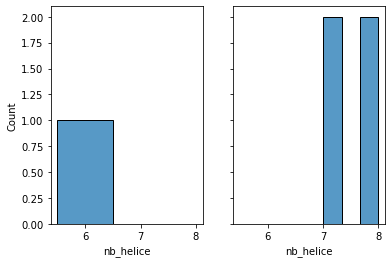

In [23]:
%matplotlib inline
df_denovo = pd.read_json(f"rfdiffusion_de_novo.json").T
df_scaffold = pd.read_json(f"rfdiffusion_scaffold.json").T
fig, (ax1,ax2) = plt.subplots(sharex=True, sharey=True, nrows=1,ncols=2)
sns.histplot(data=df_denovo, x='nb_helice',ax=ax1)
sns.histplot(data=df_scaffold, x="nb_helice", ax=ax2)

<AxesSubplot:xlabel='rg', ylabel='Count'>

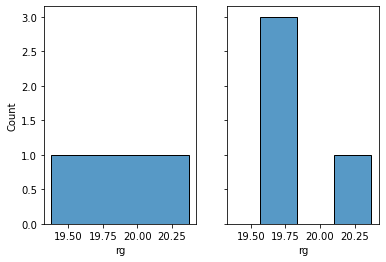

In [26]:
fig, (ax1,ax2) = plt.subplots(sharex=True, sharey=True, nrows=1,ncols=2)
sns.histplot(data=df_denovo, x='rg',ax=ax1)
sns.histplot(data=df_scaffold, x="rg", ax=ax2)

<AxesSubplot:xlabel='beta_perc', ylabel='Count'>

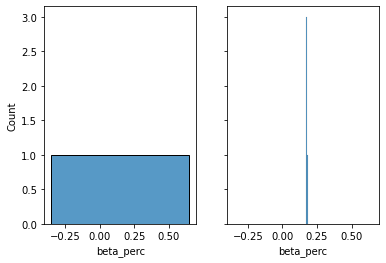

In [28]:
fig,(ax1,ax2) = plt.subplots(sharex=True, sharey=True, nrows=1,ncols=2)
sns.histplot(data=df_denovo, x='beta_perc',ax=ax1)
sns.histplot(data=df_scaffold, x="beta_perc", ax=ax2)



<AxesSubplot:xlabel='loop_perc', ylabel='Count'>

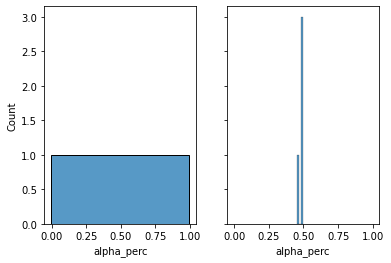

In [29]:
fig,(ax1,ax2) = plt.subplots(sharex=True, sharey=True, nrows=1,ncols=2)
sns.histplot(data=df_denovo,x="alpha_perc",ax=ax1)
sns.histplot(data=df_scaffold,x="alpha_perc",ax=ax2)

<AxesSubplot:xlabel='loop_perc', ylabel='Count'>

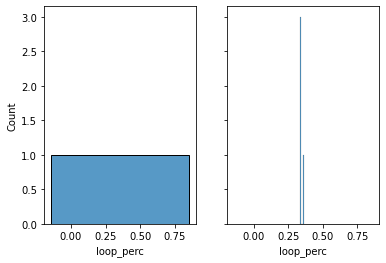

In [32]:
fig,(ax1,ax2) = plt.subplots(sharex=True, sharey=True, nrows=1,ncols=2)
sns.histplot(data=df_denovo,x="loop_perc",ax=ax1)
sns.histplot(data=df_scaffold,x="loop_perc",ax=ax2)

In [35]:
picked_denovo_bb = df_denovo.loc[(df_denovo["nb_helice"]>2)&(df_denovo["loop_perc"]>0.07)&(df_denovo["alpha_perc"]<0.94)&(df_denovo["rg"]<19)&(df_denovo["nb_helice"]<6)]
print(picked_scaffold_bb.shape)
picked_scaffold_bb =  df_scaffold.loc[(df_scaffold["nb_helice"]>2)&(df_scaffold["loop_perc"]>0.07)&(df_scaffold["alpha_perc"]<0.94)&(df_scaffold["rg"]<19)&(df_scaffold["nb_helice"]<6)]
print(df_scaffold.shape)


(0, 6)
(4, 6)


In [36]:
folder_picked_bb = "picked_denovo_bb"
if not os.path.isdir(folder_picked_bb ):
    os.mkdir(folder_picked_bb )
    
for path_bb in picked_denovo_bb.index:
    shutil.copy(output_folder+"/"+path_bb, folder_picked_bb+"/")

folder_picked_bb = "picked_scaffpmd_bb"
if not os.path.isdir(folder_picked_bb ):
    os.mkdir(folder_picked_bb )
    
for path_bb in picked_scaffold_bb.index:
    shutil.copy(output_folder+"/"+path_bb, folder_picked_bb+"/")


NameError: name 'picked_denovo_bb' is not defined

# Running ProteinMPNN

### After we picked the RFdiffusion backbones we design the sequences using ProteinMPNN:
- ProteinMPNN requires helper scripts to work, at minimum parse_multiple_chains.py and in our case we add assign_fixed_chains.py to design only the chain designed by RFdiffusion, i.e. chain A
- Other ProteinMPNN parameters are:
    - num_seq_per_target
    - sampling_temp: increases the diversity of sequence produced
    - it is also possible to change the weights of ProteinMPNN for specific tasks 

In [13]:
folder_with_pdbs="picked_bb"
output_dir="proteinmpnn"
path_for_parsed_chains="parsed_pdbs.jsonl"
path_for_assigned_chains="assigned_pdbs.jsonl"
chains_to_design="A" 

# python /software/AMD/git/dl_binder_design/mpnn_fr/ProteinMPNN/helper_scripts/parse_multiple_chains.py \
#          --input_path=$folder_with_pdbs \
#          --output_path=$path_for_parsed_chains

# python /software/AMD/git/dl_binder_design/mpnn_fr/ProteinMPNN/helper_scripts/assign_fixed_chains.py \
#         --input_path=$path_for_parsed_chains \
#         --output_path=$path_for_assigned_chains \
#         --chain_list "$chains_to_design"

os.system(f"parse_multiple_chains.py --input_path={folder_with_pdbs} --output_path={path_for_parsed_chains}")
os.system(f"assign_fixed_chains.py --input_path={path_for_parsed_chains} --output_path={path_for_assigned_chains} --chain_list={chains_to_design}")
os.system(f"protein_mpnn_run.py --jsonl_path {path_for_parsed_chains} \
        --chain_id_jsonl {path_for_assigned_chains} \
        --out_folder {output_dir} \
        --num_seq_per_target 10 \
        --sampling_temp '0.1' \
        --batch_size 1")

/rhea/scratch/brussel/vo/000/bvo00014/workshop_test/day2/test_thomas
----------------------------------------
fixed_positions_jsonl is NOT loaded
----------------------------------------
pssm_jsonl is NOT loaded
----------------------------------------
omit_AA_jsonl is NOT loaded
----------------------------------------
bias_AA_jsonl is NOT loaded
----------------------------------------
tied_positions_jsonl is NOT loaded
----------------------------------------
bias by residue dictionary is not loaded, or not provided
----------------------------------------
discarded {'bad_chars': 0, 'too_long': 0, 'bad_seq_length': 0}
----------------------------------------
Number of edges: 48
Training noise level: 0.2A
Generating sequences for: de_novo_0
10 sequences of length 236 generated in 9.7972 seconds


0

In [14]:
py.init("-mute all")

fasta_folder = output_dir+"/seqs/"
name_fasta = "picked_pdb.fa"

def get_seq_target(path):
    pose = py.pose_from_pdb(path)
    c_selector = py.rosetta.core.select.residue_selector.ChainSelector("A")
    return pose.sequence()[len(list(c_selector.selection_positions(pose))):]

def make_fasta(fasta_folder,bb_folder,fasta_name):
    to_write=[]
    seq_target = get_seq_target(glob.glob(f"{bb_folder}/*.pdb")[0])
    for seq in glob.glob(fasta_folder+"/*.fa"):
        with open(seq) as fi:
            lines = fi.readlines()
        name = seq.split("/")[-1].replace(".fa","")
        count = 1
        for i in range(0,len(lines)):
            if lines[i].startswith(">T"):
                to_write.append(f">{name}_{count}")
                to_write.append(lines[i+1].replace("\n","")+":"+ seq_target)
                count+=1
    with open(fasta_name,'w') as fi:
        for line in to_write:
            fi.writelines(line+"\n")

bb_folder ="picked_bb"
make_fasta(fasta_folder, folder_with_pdbs, name_fasta)

┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│         See LICENSE.PyRosetta.md or email license@uw.edu for details         │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2024 [Rosetta PyRosetta4.Release.python310.linux 2024.24+release.ca096dac4f43ee5ee195f87f3703a520fcf60cf9 2024-06-14T16:57:57] retrieved from: http://www.pyrosetta.org


## Running colabfold 

### <u>Initial Guess</u>:
- We already know the structure of the ACE2 binding domain, so we can give that structural information to ColabFold so the network will focus on the designed chain.
- Thus we provide the .cif of the template with modifications from https://github.com/sokrypton/ColabFold/issues/177
- Designed sequence will be new to nature, thus the MSA will not provide information. We use the single sequence mode to do the prediction without MSA 
- Then the designed sequences are picked using:
    - pLDDT > 90
    - RMSD between the design model and the ColabFold model < 1
    - pAE < 6
    - manual inspection of the ColabFold model     
    
Code modified from https://github.com/sokrypton/ColabFold

In [15]:


name_fasta = "picked_pdb.fa"
output_folder_cfold = "output_cfold"
custom_template_path = "custom_template"

# os.system(f"colabfold_batch \
#     {name_fasta} \
#     {output_folder_cfold} \
#   --num-recycle 3 \
#   --templates \
#   --msa-mode single_sequence \
#   --custom-template-path {custom_template_path}")


In [16]:
def get_data_from_fasta(path_fa):
    queries = {}
    with open(path_fa,"r") as fi:
        lines = fi.readlines()
    for i in range(0,len(lines)):
        query_sequence=""
        if lines[i].startswith(">"):
            job_name = lines[i].replace(">","")
            query_sequence = lines[i+1]
            queries[job_name] = query_sequence
    return queries    


name_fasta="picked_pdb.fa"
all_query = get_data_from_fasta(name_fasta)

jobname de_novo_0_1_1fd80_0
sequence AADEALKKALKKLKEALKEVKKLAEELKKLAKEFKKKGIKNPELVEELEKAEKKAKELAKELEEAEKQAKELAKKDKAAAVALAEDAVERAKDILAEIKAIIAKAKAE:ASFSTFKCYYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKKGGNYNYLYRLFRKSKLKPFERDTSMEIYQAGNTPCNGVKGFNCYFPLQSYGFRPTYGVGYQPYRVVVLS
length 236


COMPLETE: 100%|██████████| 300/300 [elapsed: 00:23 remaining: 00:00]


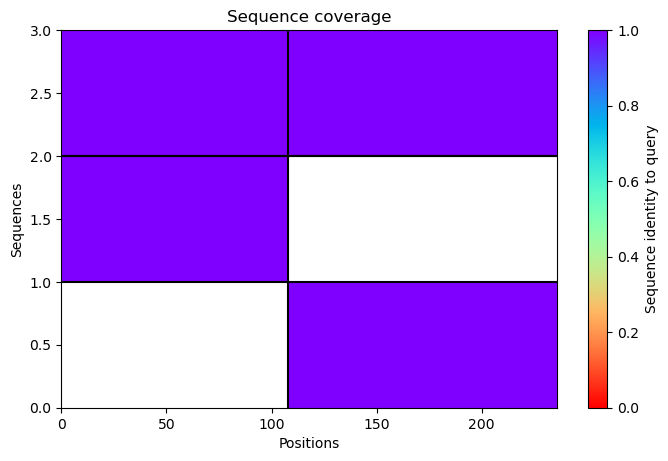

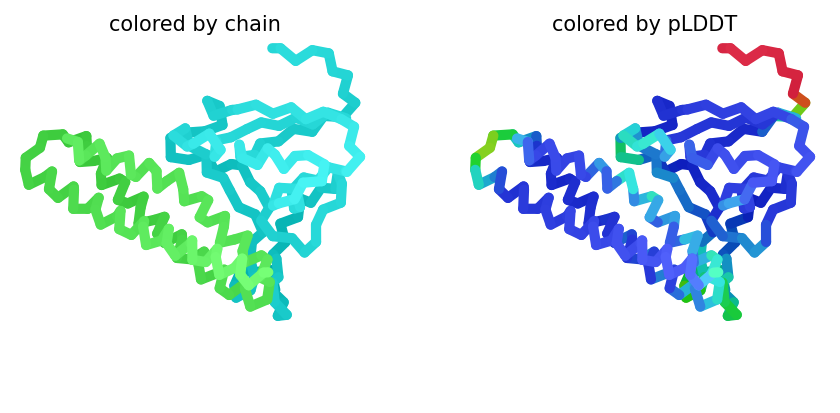

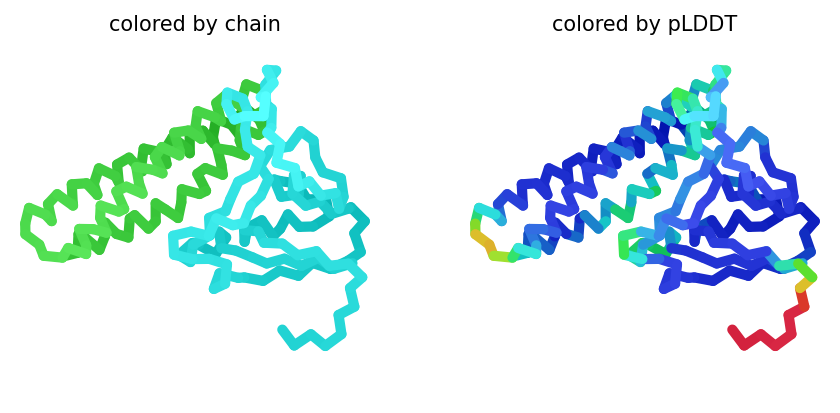

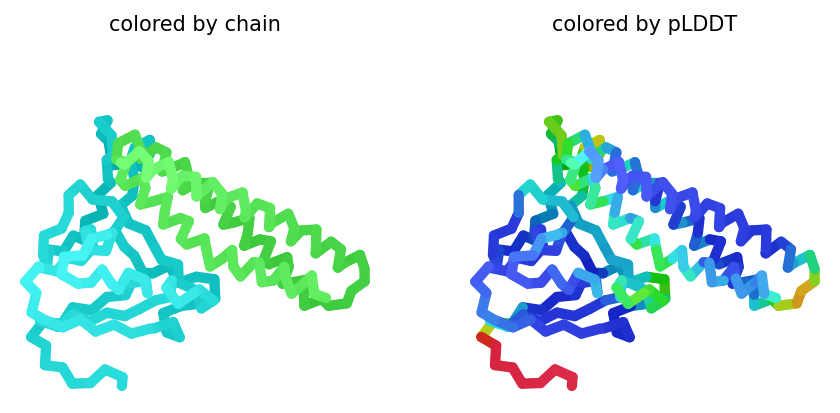

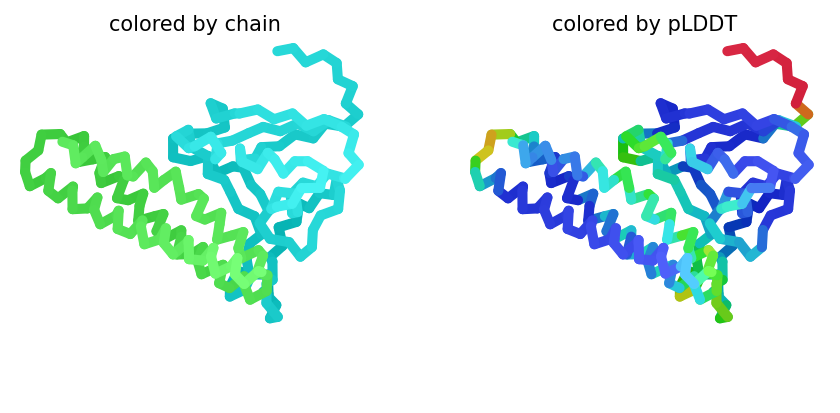

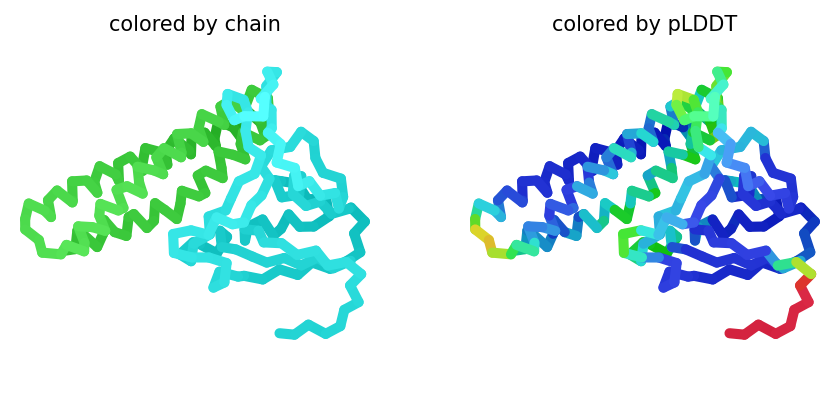

jobname de_novo_0_2_04934
sequence SAEKKYEEAKKALEKKIEEVEKLAKECKELKEKLKKEGIKDPELVKELEKAEKELEEKKKELEKALKEGEKLAKEDKEKAVALLEDKILEVEDIVKEVEALIAKAKAY:ASFSTFKCYYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKKGGNYNYLYRLFRKSKLKPFERDTSMEIYQAGNTPCNGVKGFNCYFPLQSYGFRPTYGVGYQPYRVVVLS
length 236
2024-09-09 14:07:07,032 Running on GPU
2024-09-09 14:07:07,038 Found 3 citations for tools or databases
2024-09-09 14:07:07,140 Query 1/1: de_novo_0_2_04934 (length 236)


PENDING:   0%|          | 0/300 [elapsed: 00:00 remaining: ?]

2024-09-09 14:07:08,061 Sleeping for 10s. Reason: PENDING


COMPLETE: 100%|██████████| 300/300 [elapsed: 00:12 remaining: 00:00]


2024-09-09 14:07:23,182 Sequence 0 found no templates
2024-09-09 14:07:23,765 Sequence 1 found templates: ['7bh9_E', '7bh9_E']


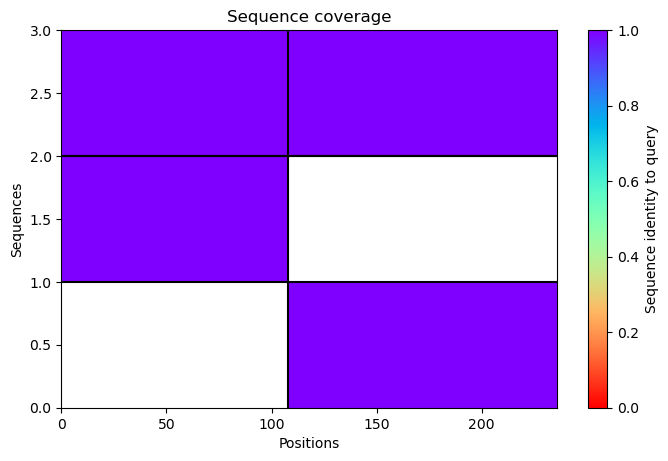

2024-09-09 14:08:02,710 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=79.6 pTM=0.477 ipTM=0.0951
2024-09-09 14:08:12,863 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=83.1 pTM=0.605 ipTM=0.323 tol=5.47
2024-09-09 14:08:22,991 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=84.1 pTM=0.635 ipTM=0.391 tol=0.555
2024-09-09 14:08:33,128 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=84 pTM=0.602 ipTM=0.324 tol=0.358
2024-09-09 14:08:33,129 alphafold2_multimer_v3_model_1_seed_000 took 65.3s (3 recycles)


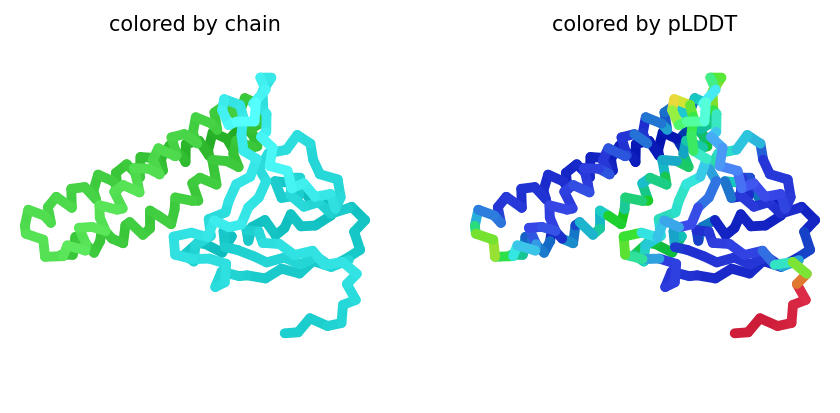

2024-09-09 14:08:43,565 alphafold2_multimer_v3_model_2_seed_000 recycle=0 pLDDT=67.8 pTM=0.476 ipTM=0.0937
2024-09-09 14:08:53,747 alphafold2_multimer_v3_model_2_seed_000 recycle=1 pLDDT=82.7 pTM=0.518 ipTM=0.146 tol=11.9
2024-09-09 14:09:03,915 alphafold2_multimer_v3_model_2_seed_000 recycle=2 pLDDT=85.4 pTM=0.613 ipTM=0.332 tol=1.56
2024-09-09 14:09:14,092 alphafold2_multimer_v3_model_2_seed_000 recycle=3 pLDDT=85.4 pTM=0.583 ipTM=0.274 tol=0.294
2024-09-09 14:09:14,092 alphafold2_multimer_v3_model_2_seed_000 took 40.7s (3 recycles)


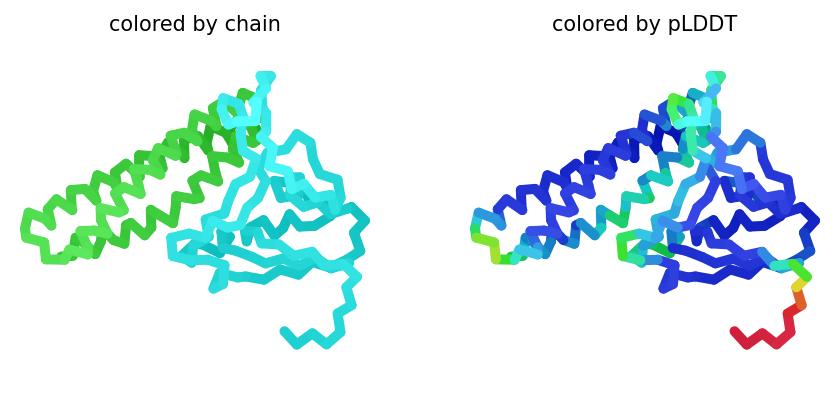

2024-09-09 14:09:24,555 alphafold2_multimer_v3_model_3_seed_000 recycle=0 pLDDT=80.2 pTM=0.506 ipTM=0.125


KeyboardInterrupt: 

In [18]:
#inputs:

num_relax=0
template_mode="custom"
#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
# from google.colab import files

python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

# query_sequence = 'PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK' #@param {type:"string"}
#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer
# jobname = 'test' #@param {type:"string"}
# number of models to use
# num_relax = 0 #@param [0, 1, 5] {type:"raw"}
#@markdown - specify how many of the top ranked structures to relax using amber
# template_mode = "none" #@param ["none", "pdb100","custom"]
#@markdown - `none` = no template information is used. `pdb100` = detect templates in pdb100 (see [notes](#pdb100)). `custom` - upload and search own templates (PDB or mmCIF format, see [notes](#custom_templates))

use_amber = num_relax > 0

# remove whitespaces
for jobname,query_sequence in all_query.items():
    query_sequence = "".join(query_sequence.split())

    basejobname = "".join(jobname.split())
    basejobname = re.sub(r'\W+', '', basejobname)
    jobname = add_hash(basejobname, query_sequence)

    # check if directory with jobname exists
    def check(folder):
      if os.path.exists(folder):
        return False
      else:
        return True
    if not check(jobname):
      n = 0
      while not check(f"{jobname}_{n}"): n += 1
      jobname = f"{jobname}_{n}"

    # make directory to save results
    os.makedirs(jobname, exist_ok=True)

    # save queries
    queries_path = os.path.join(jobname, f"{jobname}.csv")
    with open(queries_path, "w") as text_file:
      text_file.write(f"id,sequence\n{jobname},{query_sequence}")

    if template_mode == "pdb100":
      use_templates = True
      custom_template_path = None
    elif template_mode == "custom":
      custom_template_path = "custom_template/"
      # os.makedirs(custom_template_path, exist_ok=True)
      # uploaded = files.upload()
      use_templates = True
      # for fn in uploaded.keys():
      #   os.rename(fn,os.path.join(custom_template_path,fn))
    else:
      custom_template_path = None
      use_templates = False


    try : assert os.path.exists(custom_template_path)
    except: AssertionError:f"Error in custom_template_path"

    print("jobname",jobname)
    print("sequence",query_sequence)
    print("length",len(query_sequence.replace(":","")))
    msa_mode="single_sequence"
    pair_mode="unpaired_paired"
    a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
    with open(a3m_file, "w") as text_file:
        text_file.write(">1\n%s" % query_sequence)

        #@markdown ### Advanced settings
    model_type = "auto" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3", "deepfold_v1"]
    num_recycles = "3" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]

    recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
    relax_max_iterations = 200 #@param [0, 200, 2000] {type:"raw"}

    pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}

    max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
    num_seeds = 1 #@param [1,2,4,8,16] {type:"raw"}
    use_dropout = False #@param {type:"boolean"}

    num_recycles = int(num_recycles)
    recycle_early_stop_tolerance = None
    if max_msa == "auto": max_msa = None
    dpi=200
    save_all=False
    save_recycles=False

    #@title Run Prediction
    display_images = True #@param {type:"boolean"}

    try:
      K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
    except:
      K80_chk = "0"
      pass
    if "1" in K80_chk:
      print("WARNING: found GPU Tesla K80: limited to total length < 1000")
      if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
        del os.environ["TF_FORCE_UNIFIED_MEMORY"]
      if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
        del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]



    # For some reason we need that to get pdbfixer to import
    if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
        sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

    def input_features_callback(input_features):
      if display_images:
        plot_msa_v2(input_features)
        plt.show()
        plt.close()

    def prediction_callback(protein_obj, length,
                            prediction_result, input_features, mode):
      model_name, relaxed = mode
      if not relaxed:
        if display_images:
          fig = plot_protein(protein_obj, Ls=length, dpi=150)
          plt.show()
          plt.close()

    result_dir = output_folder_cfold
    log_filename = os.path.join(jobname,"log.txt")
    setup_logging(Path(log_filename))

    queries, is_complex = get_queries(queries_path)
    model_type = set_model_type(is_complex, model_type)

    if "multimer" in model_type and max_msa is not None:
      use_cluster_profile = False
    else:
      use_cluster_profile = True

    download_alphafold_params(model_type, Path("."))
    results = run(
        queries=queries,
        result_dir=result_dir,
        use_templates=use_templates,
        custom_template_path=custom_template_path,
        num_relax=num_relax,
        msa_mode=msa_mode,
        model_type=model_type,
        num_models=5,
        num_recycles=num_recycles,
        relax_max_iterations=relax_max_iterations,
        recycle_early_stop_tolerance=recycle_early_stop_tolerance,
        num_seeds=num_seeds,
        use_dropout=use_dropout,
        model_order=[1,2,3,4,5],
        is_complex=is_complex,
        data_dir=Path("."),
        keep_existing_results=False,
        rank_by="auto",
        pair_mode=pair_mode,
        pairing_strategy=pairing_strategy,
        stop_at_score=float(100),
        prediction_callback=prediction_callback,
        dpi=dpi,
        zip_results=False,
        save_all=save_all,
        max_msa=max_msa,
        use_cluster_profile=use_cluster_profile,
        input_features_callback=input_features_callback,
        save_recycles=save_recycles,
        user_agent="colabfold/google-colab-main",
    )
    # results_zip = f"{jobname}.result.zip"
    # os.system(f"zip -r {results_zip} {jobname}")

## Analyze ColabFold results:

In [21]:
def load_cbatch_results(dir_res):
    dict = {}
    if os.path.exists(dir_res.replace("/",".json")):
        fi = open(dir_res.replace("/",".json"),"r")
        df =  pd.DataFrame(json.load(fi))
        fi.close()
        return df

    for res in glob.glob(dir_res+"*_scores_*.json"):
        with open(res,"r") as fi:
            data = json.load(fi)
            mean_plddt = sum(data["plddt"]) / len(data["plddt"])
            mean_pae_res = []
            for i in data["pae"]:
                mean_pae_res.append(sum(i)/len(i))
            dict[res.split("/")[-1]] = {"mean_plddt":mean_plddt, "ptm":data["ptm"], "pae":sum(mean_pae_res)/len(mean_pae_res)}
    df = pd.DataFrame(dict).T
    
    df.to_json(path_or_buf=dir_res.replace("/",".json"))
        
    return df


def load_tmalign_res(path_json):
    with open(path_json,'r') as j:
        dict = json.load(j)
        foo_df = pd.DataFrame(dict).T
        new_index=[]
        for index in foo_df.index:
            new_index.append(index.split("/")[-1].replace("unrelaxed","scores").replace(".pdb",".json"))
        foo_df.index = new_index
        return foo_df

def json_to_pdb(json_path):
    return json_path.replace("scores","unrelaxed").replace("json","pdb")


os.system("python run_tmalign_workshop.py picked_bb/ output_cfold/ tmalign_cfold.json")
df_tmalign = load_tmalign_res("tmalign_cfold.json")

df_cfold = pd.concat([load_cbatch_results("output_cfold/"), load_tmalign_res("tmalign_cfold.json")], axis=1)


In [22]:
df_cfold

,mean_plddt,ptm,pae,tmscore,RMSD
de_novo_0_1_1fd80_0_scores_rank_001_alphafold2_multimer_v3_model_1_seed_000.json,86.385932,0.71,8.339727,0.59863,3.65
de_novo_0_2_04934_scores_alphafold2_multimer_v3_model_2_seed_000.json,85.466271,0.58,11.965870,0.57656,3.37
de_novo_0_2_04934_scores_alphafold2_multimer_v3_model_1_seed_000.json,83.984831,0.60,10.806005,0.57513,3.18
de_novo_0_1_1fd80_0_scores_rank_002_alphafold2_multimer_v3_model_2_seed_000.json,85.321398,0.65,10.054679,0.58537,3.36
de_novo_0_1_1fd80_0_scores_rank_004_alphafold2_multimer_v3_model_3_seed_000.json,82.727373,0.60,11.205670,0.60741,3.68
de_novo_0_1_1fd80_0_scores_rank_005_alphafold2_multimer_v3_model_4_seed_000.json,82.414873,0.56,12.422467,0.59856,3.44
de_novo_0_1_1fd80_0_scores_rank_003_alphafold2_multimer_v3_model_5_seed_000.json,82.435508,0.61,10.980126,0.58996,3.48


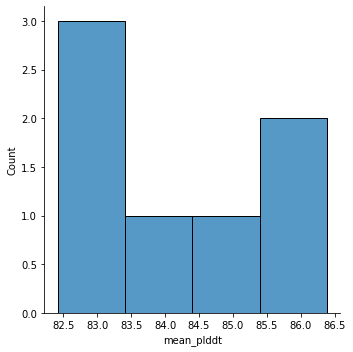

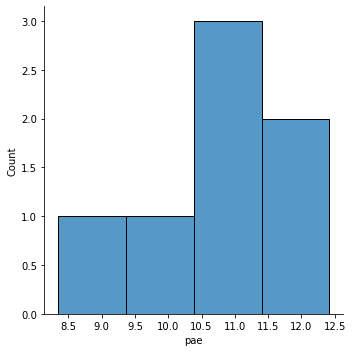

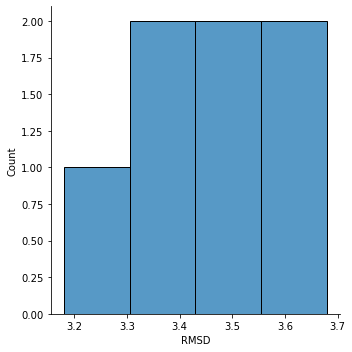

In [23]:
%matplotlib inline
sns.displot(data=df_cfold, x="mean_plddt")
sns.displot(data=df_cfold, x="pae")
sns.displot(data=df_cfold, x="RMSD")

In [ ]:
picked = df_cfold.loc[(df_cfold["RMSD"]<1)&(df_cfold["mean_plddt"]>90)&(df_cfold["pae"]<5)]